# Exercise 4 (Sensitivity analysis of a dynamical model for cellular metabolism)

Glucose is a fundamental constituent of cellular metabolism, serving as a primary energy source and precursor for biosynthetic processes through pathways such as glycolysis, the citric acid cycle, and oxidative phosphorylation. Simply put, cells can exploit glucose supplies, available in the surrounding environment, by absorbing and converting them into energy resources stored in the form of ATP (adenosine triphosphate).

The following system of ordinary differential equations describes the relationship between glucose uptake and cellular metabolism over time using the so-called *Michaelis-Menten Kinetics* model,

$$
\frac{dG}{dt} = -\frac{V_{\max} G}{K_m + G}, \quad
\frac{dS}{dt} = \frac{V_{\max} G}{K_m + G} - \alpha S, \quad
\frac{dE}{dt} = \alpha S - \beta E.
$$

Here,

- $G$ is the extracellular glucose concentration (mmol/L),
- $S$ is the intracellular substrate concentration (e.g., mmol/L),
- $E$ is the energy (ATP) concentration inside the cell (e.g., mmol/L),

whereas the model parameters are:

- $V_{\max}$: maximum rate of glucose uptake (mmol/L/hr),
- $K_m$: Michaelis-Menten constant for glucose uptake (mmol/L),
- $\alpha$: Rate of ATP production from glucose metabolism (mmol/L/hr per mmol/L substrate),
- $\beta$: ATP degradation rate (mmol/L/hr).

Given initial conditions and suitable values for the model parameters, one can solve Eq. (8) numerically and thus simulate the dynamics of the system: cf. Figure 4. We refer to the **auxiliary notebook** for a practical demonstration and related code.


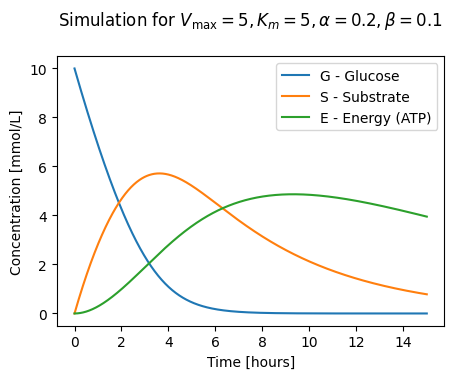

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp
import pandas as pd

T = 15 # Final time
z0 = np.array([10.0, 0.0, 0.0]) # Initial condition for z = [G, S, E]

# ODE model
def F(z, Vmax, Km, alpha, beta):
  G, S, E = z
  return np.array([-Vmax*G/(Km+G), Vmax*G/(Km+G)-alpha*S, alpha*S-beta*E])

# ODE simulator
def metabolic(Vmax, Km, alpha, beta):
  solution = solve_ivp(lambda t, z : F(z, Vmax, Km, alpha, beta), t_span = (0, T), y0 = z0, t_eval=np.linspace(0, T, 1000)) # solve dz / dt = f(t, z)
  t = solution.t
  G, S, E = solution.y
  return t, G, S, E

# Example
t, G, S, E = metabolic(5.0, 5.0, 0.2, 0.1)

plt.figure(figsize = (5, 3.5))
plt.plot(t, G, label = 'G - Glucose')
plt.plot(t, S, label = 'S - Substrate')
plt.plot(t, E, label = 'E - Energy (ATP)')
plt.xlabel("Time [hours]")
plt.ylabel("Concentration [mmol/L]")
plt.legend()
plt.title("Simulation for $V_{\\max}=5,K_m=5,\\alpha=0.2,\\beta=0.1$\n")
plt.show()

Assume that, at time $t = 0$, one has $G = 10$ mmol/L, $S = 0$ mmol/L, and $E = 0$ mmol/L. Set the terminal time to $T = 15h$. We are interested in studying the behavior of the following quantities,

$$
Y_1 := G(T), \quad Y_2 := \max_{t \in [0,T]} E(t), \quad Y_3 := \min \{t : G(t) = S(t), \, 0 \leq t \leq T\},
$$

i.e.: the amount of glucose not absorbed and still available outside the cell ($Y_1$), the maximum energy available throughout the process ($Y_2$), the time at which internal and external glucose supplies balance out ($Y_3$). For this analysis, we consider the following ranges for the physical parameters,

$$
5 \leq V_{\max}, K_m \leq 10, \quad 0.1 \leq \alpha, \beta \leq 0.5.
$$




### Tasks

**(a)** Quantify the sensitivity of $Y_1$, $Y_2$, and $Y_3$ (separately) with respect to $V_{\max}, K_m, \alpha, \beta$. To this end, estimate Sobol indices (both main and total effects) using Saltelli’s method with $N = 1024$ samples. Are the results interpretable?



In [ ]:
from scipy.stats.qmc import Sobol

def saltelli_ABC(N, p, xmin, xmax):
  """N = sample size.
     p = number of inputs.
     xmin = minimum value of the inputs (either a scalar or an array of scalars).
     xmax = minimum value of the inputs (either a scalar or an array of scalars).

     Returns: A (N x p matrix), B (N x p matrix), C (list of p matrices, all N x p).
  """
  sobol = Sobol(d=2*p, scramble=True)
  AB = sobol.random(N)
  A, B = AB[:, :p]*(xmax-xmin)+xmin, AB[:, p:]*(xmax-xmin)+xmin

  C = [np.zeros((N, p))]*p
  for i in range(p):
    C[i] = B + 0.0
    C[i][:, i] = A[:, i]

  return A, B, C

def saltelli_Si(yA, yB, yC):
  """yA = vector of length N.
     yB = vector of length N.
     yC = list containing p vectors, each of length N

     Returns: Si (list of main effects), STi (list of total effects)
  """
  N, p = len(yA), len(yC)
  Si  = [(yA @ yC[i]/N - yA.mean()**2)/yA.var() for i in range(p)]
  STi = [1.0 - (yB @ yC[i]/N - yA.mean()**2)/yA.var() for i in range(p)]
  return Si, STi

In [ ]:
clamp01 = lambda s: np.minimum(np.maximum(s, 0), 1)

def sobol_indices(model, p, xmin, xmax, N):
  A, B, C = saltelli_ABC(N, p, xmin, xmax)

  yA = model(A)
  yB = model(B)
  yC = [model(Ci) for Ci in C]

  Si, STi = saltelli_Si(yA, yB, yC)

  return clamp01(Si), clamp01(STi)

In [ ]:
# Quantity of interest

# Amount of glucose not absorbed and still available outside the cell
def Y1(t, G, S, E):
  return G[-1]

# Maximum energy available throughout the process
def Y2(t, G, S, E):
  return E.max()

# Time at which internal and external glucose supplies balance out
def Y3(t, G, S, E):
  return t[np.argmin(np.abs(G-S))]

In [ ]:
def GSEqoi(X, QoI):
  nx = len(X)
  output = np.zeros(nx)
  for j in range(nx):
    Vmax, Km, alpha, beta = X[j]
    t, G, S, E = metabolic(Vmax, Km, alpha, beta)
    output[j] = QoI(t, G, S, E)
  return output

In [ ]:
Si, STi = sobol_indices(lambda X: GSEqoi(X, Y1), p = 4, xmin = np.array([5, 5, 0.1, 0.1]), xmax = np.array([10, 10, 0.5, 0.5]), N = 1024)
pd.DataFrame({'Main effect':Si, 'Total effect':STi}, index = ["Vmax", "Km", "alpha", "beta"])

,Main effect,Total effect
Vmax,0.295630,0.815370
Km,0.179868,0.691001
alpha,0.000000,0.015124
beta,0.000000,0.015125


In [ ]:
Si, STi = sobol_indices(lambda X: GSEqoi(X, Y2), p = 4, xmin = np.array([5, 5, 0.1, 0.1]), xmax = np.array([10, 10, 0.5, 0.5]), N = 1024)
pd.DataFrame({'Main effect':Si, 'Total effect':STi}, index = ["Vmax", "Km", "alpha", "beta"])

,Main effect,Total effect
Vmax,0.011087,0.015004
Km,0.005637,0.006773
alpha,0.328636,0.333451
beta,0.647910,0.653231


In [ ]:
Si, STi = sobol_indices(lambda X: GSEqoi(X, Y3), p = 4, xmin = np.array([5, 5, 0.1, 0.1]), xmax = np.array([10, 10, 0.5, 0.5]), N = 1024)
pd.DataFrame({'Main effect':Si, 'Total effect':STi}, index = ["Vmax", "Km", "alpha", "beta"])

,Main effect,Total effect
Vmax,0.017422,0.718424
Km,0.058689,0.636367
alpha,0.316763,0.904869
beta,0.001098,0.000000


**(b)** Run a convergence analysis to see whether the number of samples used at point (a) suffices.


In [ ]:
# List of sample sizes to test for convergence
sample_sizes = [256, 512, 1024, 2048, 4096]

# Create dictionaries to store Sobol indices for each parameter for each sample size
sobol_main_indices = { 'Vmax': [], 'Km': [], 'alpha': [], 'beta': [] }
sobol_total_indices = { 'Vmax': [], 'Km': [], 'alpha': [], 'beta': [] }

for N in sample_sizes:
    Si, STi = sobol_indices(lambda X: GSEqoi(X, Y1), p=4,
                              xmin=np.array([5, 5, 0.1, 0.1]),
                              xmax=np.array([10, 10, 0.5, 0.5]),
                              N=N)
    # Assuming Si and STi are arrays of length 4 corresponding to [Vmax, Km, alpha, beta]
    sobol_main_indices['Vmax'].append(Si[0])
    sobol_main_indices['Km'].append(Si[1])
    sobol_main_indices['alpha'].append(Si[2])
    sobol_main_indices['beta'].append(Si[3])

    sobol_total_indices['Vmax'].append(STi[0])
    sobol_total_indices['Km'].append(STi[1])
    sobol_total_indices['alpha'].append(STi[2])
    sobol_total_indices['beta'].append(STi[3])


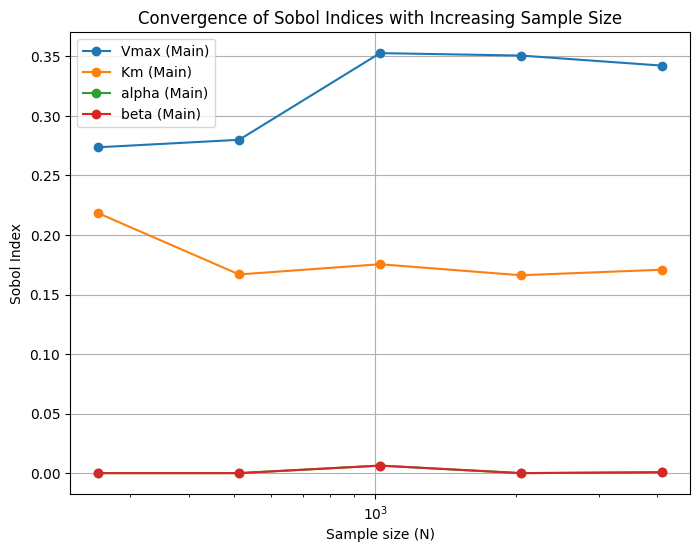

In [ ]:
# Plot the results for each parameter
parameters = ['Vmax', 'Km', 'alpha', 'beta']
plt.figure(figsize=(8, 6))
for param in parameters:
    plt.plot(sample_sizes, sobol_main_indices[param], marker='o', label=f'{param} (Main)')

plt.xlabel('Sample size (N)')
plt.ylabel('Sobol Index')
plt.title('Convergence of Sobol Indices with Increasing Sample Size')
plt.legend()
plt.xscale('log')  # Optional: log-scale for N if sample sizes vary widely
plt.grid(True)
plt.show()

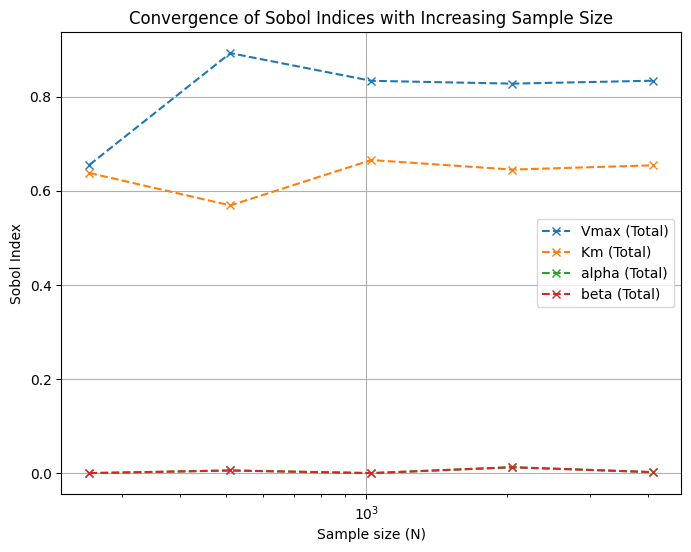

In [ ]:
# Plot the results for each parameter
parameters = ['Vmax', 'Km', 'alpha', 'beta']
plt.figure(figsize=(8, 6))
for param in parameters:
    plt.plot(sample_sizes, sobol_total_indices[param], marker='x', linestyle='--', label=f'{param} (Total)')

plt.xlabel('Sample size (N)')
plt.ylabel('Sobol Index')
plt.title('Convergence of Sobol Indices with Increasing Sample Size')
plt.legend()
plt.xscale('log')  # Optional: log-scale for N if sample sizes vary widely
plt.grid(True)
plt.show()


Let us focus on the first two quantities of interest. We would like to speed up the sensitivity analysis by introducing a neural network surrogate, formally replacing the ODE solver.

**(c)** Generate $M = 500$ simulations by drawing random values for the model parameters (uniformly in their parameter range). For each simulation, compute the two quantities of interest $Y_1$ and $Y_2$. Train a neural network model $\phi$ to learn the map

$$
\mathbb{R}^4 \ni [V_{\max}, K_m, \alpha, \beta]^\top \mapsto [\log Y_1, \log Y_2]^\top \in \mathbb{R}^2.
$$

To this end, split your data and use 300 simulations for optimization, 100 for validation, and 100 for testing.



In [ ]:
import os
import torch
from torch import nn

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using {device} device")

Using cpu device


In [ ]:
# Generate M = 500 simulations
M = 500
data = np.random.uniform(low = [5, 5, 0.1, 0.1], high = [10, 10, 0.5, 0.5], size = (M, 4))

data = torch.from_numpy(data)
train_set = data[:300]
val_set = data[300:400]
test_set = data[400:]
train_set.shape, val_set.shape, test_set.shape

(torch.Size([300, 4]), torch.Size([100, 4]), torch.Size([100, 4]))

In [ ]:
data

tensor([[7.0297, 6.4897, 0.1078, 0.3239],
        [8.1844, 6.4135, 0.4405, 0.1185],
        [8.8469, 5.9491, 0.1812, 0.4198],
        ...,
        [7.4218, 7.1357, 0.4441, 0.3191],
        [9.3384, 8.0976, 0.2751, 0.1312],
        [9.0573, 5.8169, 0.1001, 0.3077]], dtype=torch.float64)

In [ ]:
# Compute the two qoi Y1 and Y2
logY1_train = torch.log(torch.tensor(GSEqoi(train_set.numpy(), Y1)))
logY2_train = torch.log(torch.tensor(GSEqoi(train_set.numpy(), Y2)))

logY1_val = torch.log(torch.tensor(GSEqoi(val_set.numpy(), Y1)))
logY2_val = torch.log(torch.tensor(GSEqoi(val_set.numpy(), Y2)))

logY1_test = torch.log(torch.tensor(GSEqoi(test_set.numpy(), Y1)))
logY2_test = torch.log(torch.tensor(GSEqoi(test_set.numpy(), Y2)))

In [ ]:
# Build the neural network
class NeuralNetwork(nn.Module):
    def __init__(self, p, n):
        super().__init__()
        self.leaky_relu_stack = nn.Sequential(
            nn.Linear(p, 30),
            nn.ReLU(),
            nn.Linear(30, 30),
            nn.ReLU(),
            nn.Linear(30, n),
        )

    def forward(self, x):
        output = self.leaky_relu_stack(x)
        return output

In [ ]:
p = 4
n = 2
nn_model = NeuralNetwork(p,n).to(device)
print(nn_model)

NeuralNetwork(
  (leaky_relu_stack): Sequential(
    (0): Linear(in_features=4, out_features=30, bias=True)
    (1): ReLU()
    (2): Linear(in_features=30, out_features=30, bias=True)
    (3): ReLU()
    (4): Linear(in_features=30, out_features=2, bias=True)
  )
)


In [ ]:
# Convert data to float tensor
train_set = train_set.float().to(device)
val_set = val_set.float().to(device)
test_set = test_set.float().to(device)

logY1_train = logY1_train.float().to(device)
logY2_train = logY2_train.float().to(device)
logY1_val = logY1_val.float().to(device)
logY2_val = logY2_val.float().to(device)
logY1_test = logY1_test.float().to(device)
logY2_test = logY2_test.float().to(device)

In [ ]:
# Learning rate
learning_rate = 1e-3

# Stack the targets together
train_targets = torch.stack((logY1_train, logY2_train), dim=1)
val_targets = torch.stack((logY1_val, logY2_val), dim=1)
test_targets = torch.stack((logY1_test, logY2_test), dim=1)

# Define loss function
loss_fn = nn.MSELoss()

# Use full-batch gradient descent
optimizer = torch.optim.SGD(nn_model.parameters(), lr=learning_rate)  # Adjust learning rate as needed

# Training loop
train_losses = []
val_losses = []
num_epochs = 1000  # Set the number of epochs
for epoch in range(num_epochs):
    total_train_loss = 0.0
    for i in range(train_set.shape[0]):  # Loop over each sample
        sample = train_set[i].unsqueeze(0)  # Add batch dimension (1,4)
        target = train_targets[i].unsqueeze(0)  # Target shape (1,2)

        # Forward pass
        output = nn_model(sample)

        # Compute loss
        loss = loss_fn(output, target)
        total_train_loss += loss.item()

        # Backward pass & optimization step
        optimizer.zero_grad()  # Clear previous gradients
        loss.backward()        # Compute gradients / Backpropagation
        optimizer.step()       # Update model / Gradient Descent


    # Compute average training loss
    avg_train_loss = total_train_loss / train_set.shape[0]
    train_losses.append(avg_train_loss)


    # Validation: Evaluate on the full validation set
    nn_model.eval()  # Set model to evaluation mode
    with torch.no_grad():  # No need to compute gradients
        val_outputs = nn_model(val_set)
        val_loss = loss_fn(val_outputs, val_targets).item()  # Compute MSE loss
        val_losses.append(val_loss)

    nn_model.train()  # Switch back to training mode

    # Print progress
    print(f"Epoch [{epoch+1}/{num_epochs}], Train Loss: {avg_train_loss:.6f}, Val Loss: {val_loss:.6f}")


Epoch [1/1000], Train Loss: 5.332809, Val Loss: 1.563033
Epoch [2/1000], Train Loss: 1.590423, Val Loss: 1.173666
Epoch [3/1000], Train Loss: 1.422602, Val Loss: 1.120727
Epoch [4/1000], Train Loss: 1.288274, Val Loss: 1.066579
Epoch [5/1000], Train Loss: 1.203303, Val Loss: 1.015630
Epoch [6/1000], Train Loss: 1.129695, Val Loss: 0.969494
Epoch [7/1000], Train Loss: 1.057603, Val Loss: 0.930812
Epoch [8/1000], Train Loss: 1.000962, Val Loss: 0.895460
Epoch [9/1000], Train Loss: 0.949505, Val Loss: 0.855550
Epoch [10/1000], Train Loss: 0.899910, Val Loss: 0.817922
Epoch [11/1000], Train Loss: 0.855266, Val Loss: 0.781802
Epoch [12/1000], Train Loss: 0.810942, Val Loss: 0.747406
Epoch [13/1000], Train Loss: 0.766611, Val Loss: 0.714001
Epoch [14/1000], Train Loss: 0.730210, Val Loss: 0.681548
Epoch [15/1000], Train Loss: 0.691447, Val Loss: 0.650009
Epoch [16/1000], Train Loss: 0.655009, Val Loss: 0.617179
Epoch [17/1000], Train Loss: 0.620408, Val Loss: 0.585958
Epoch [18/1000], Train 

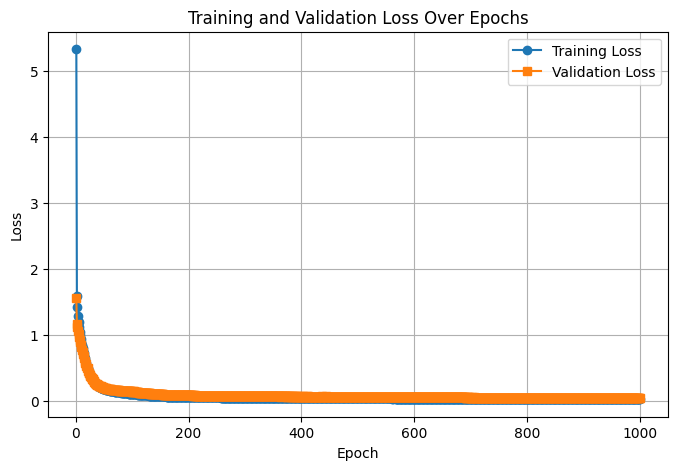

In [ ]:
# Plot loss curves
plt.figure(figsize=(8, 5))
plt.plot(range(1, num_epochs + 1), train_losses, label="Training Loss", marker='o')
plt.plot(range(1, num_epochs + 1), val_losses, label="Validation Loss", marker='s')
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training and Validation Loss Over Epochs")
plt.legend()
plt.grid(True)
plt.show()


In [ ]:
# Set model to evaluation mode
nn_model.eval()

# No gradient computation during evaluation
with torch.no_grad():
    test_predictions = nn_model(test_set)  # Get model predictions
    mse_test = loss_fn(test_targets, test_predictions)

# Print MSE
print(f"Test MSE: {mse_test:.6f}")

Test MSE: 0.033071


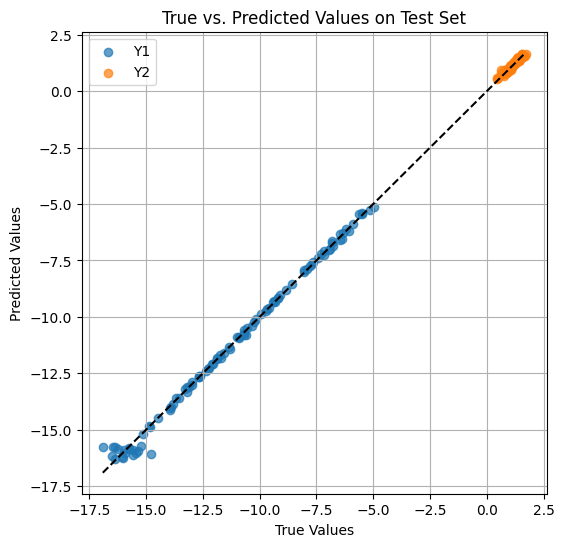

In [ ]:
# Plot True vs. Predicted values
plt.figure(figsize=(6, 6))
plt.scatter(test_targets[:, 0], test_predictions[:, 0], label="Y1", alpha=0.7)
plt.scatter(test_targets[:, 1], test_predictions[:, 1], label="Y2", alpha=0.7)
plt.plot([test_targets.min(), test_targets.max()], [test_targets.min(), test_targets.max()], "k--")  # y=x line
plt.xlabel("True Values")
plt.ylabel("Predicted Values")
plt.title("True vs. Predicted Values on Test Set")
plt.legend()
plt.grid()
plt.show()

**(d)** Let

$$
m(V_{\max}, K_m, \alpha, \beta) := e^{\phi(V_{\max}, K_m, \alpha, \beta)}
$$

be the model surrogate for $Y_1$ and $Y_2$. Repeat the sensitivity analysis at point (a) using the surrogate model rather than the ODE solver. Are the results comparable? How much faster is the neural network model?

In [ ]:
def surrogate_model(X):
  Y1, Y2 = nn_model(X)
  return torch.exp(outputs)

In [ ]:
def sobol_indices_surrogate_Y1(surr_model, p, xmin, xmax, N):
  A, B, C = saltelli_ABC(N, p, xmin, xmax)

  A,B,C = torch.Tensor(A).float(), torch.Tensor(B).float(), torch.Tensor(C).float()

  yA = surr_model(A)[:, 0].detach().numpy()
  yB = surr_model(B)[:, 0].detach().numpy()
  yC = [surr_model(Ci)[:, 0].detach().numpy() for Ci in C]

  Si, STi = saltelli_Si(yA, yB, yC)

  return clamp01(Si), clamp01(STi)

In [ ]:
def sobol_indices_surrogate_Y2(surr_model, p, xmin, xmax, N):
  A, B, C = saltelli_ABC(N, p, xmin, xmax)

  A,B,C = torch.Tensor(A).float(), torch.Tensor(B).float(), torch.Tensor(C).float()

  yA = surr_model(A)[:, 1].detach().numpy()
  yB = surr_model(B)[:, 1].detach().numpy()
  yC = [surr_model(Ci)[:, 1].detach().numpy() for Ci in C]

  Si, STi = saltelli_Si(yA, yB, yC)

  return clamp01(Si), clamp01(STi)

In [ ]:
Si, STi = sobol_indices_surrogate_Y1(surrogate_model, p = 4, xmin = np.array([5, 5, 0.1, 0.1]), xmax = np.array([10, 10, 0.5, 0.5]), N = 1024)
pd.DataFrame({'Main effect':Si, 'Total effect':STi}, index = ["Vmax", "Km", "alpha", "beta"])

,Main effect,Total effect
Vmax,0.338103,0.796904
Km,0.189144,0.635179
alpha,0.006180,0.001328
beta,0.006284,0.006889


In [ ]:
Si, STi = sobol_indices_surrogate_Y2(surrogate_model, p = 4, xmin = np.array([5, 5, 0.1, 0.1]), xmax = np.array([10, 10, 0.5, 0.5]), N = 1024)
pd.DataFrame({'Main effect':Si, 'Total effect':STi}, index = ["Vmax", "Km", "alpha", "beta"])

,Main effect,Total effect
Vmax,0.011762,0.052773
Km,0.001700,0.027265
alpha,0.352140,0.362533
beta,0.599012,0.626398
